In [65]:
import os
import glob
import pandas as pd
import numpy as np
from functools import reduce  
from pathlib import Path


import seaborn as sns
from dask import dataframe as dd

import matplotlib.pyplot as plt
import pickle
from scipy.stats import wasserstein_distance
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as tic

plt.rcParams['figure.dpi'] = 200
import sys

In [66]:
# find current working directoy
cwd_path = Path().absolute()
data_root = cwd_path.parent.parent / "data"
experiment = "cerebellum"
chrom_list = [f"chr{x}" for x in range(1, 20)]
chrom_list.append("chrX")

In [67]:
# read all celltypes information
leidens = ["0+1", "2", "4", "6+11", "7"]
cell_types = ["Granule", "Bergmann", "MLI1", "Purkinje", "MLI2+PLI"]
df_dict = {}
for ld, ct in zip(leidens, cell_types):
    df = pd.read_csv(str(data_root / experiment / "IF_ensemble" / f"IF_markers_median_200kb_binned_cerebellum_leiden_{ld}.csv"))
    df_dict[ct] = df
    
# get gene name
meta = pd.read_csv(str(data_root / "annotation" / "LC1-100k-09022022-mm10-200kb-meta.csv") )
meta["density"] = meta["density"].fillna(0).astype(int)

genes = pd.read_csv(str(data_root / "annotation" / "mm10_25kb_bins_genes_09022022.csv"))
genes = genes[["200kb name", "gene"]].drop_duplicates()
genes = genes[genes["gene"] != "."]
g_all_df = genes.groupby("200kb name")[["gene"]].agg(lambda x: ",".join(x)).reset_index()
meta = meta.merge(g_all_df, left_on = "200kb name", right_on = "200kb name", how = "left" ,suffixes = ["_list", ""])

# read in selected marker peak calling data
final_df = pd.read_csv(str( data_root / "cerebellum" / "peak_detection" /"110822_all_markers_lncRNA_all_peaks.csv"))

# rank final dataframe
final_df["chrom_id"] = final_df["200kb name"].str.split("-").str[0].str[3:].replace("X", 20).astype(int)
final_df["bin_id"] = final_df["200kb name"].str.split("-").str[1].str[1:].astype(int)
final_df = final_df.sort_values(by = [ "chrom_id", "bin_id", "celltype"])

sc_df = pd.read_csv(str( data_root / experiment / "differential_expression" / "RNA_DE" / "cerebellum_VII_RLogNorm_ensemble.csv"))
sc_df.rename(columns = {"Unnamed: 0": "gene"}, inplace = True)

# Get the repressive bin defination for different markers

In [68]:
bin_dict = {}

# get the H4K20me3 trong and week bins
H4_df = pd.read_csv(str(data_root / experiment / "peak_detection" / "H4K20me3-peaks-H4K20me5_cat5-weak1-strong2.csv"))
H4_df = H4_df[H4_df["chrom"] != "chrX"]
b_weak = H4_df[H4_df["H4K20me3_cat5"] == 1]["200kb name"].values
b_strong = H4_df[H4_df["H4K20me3_cat5"] == 2]["200kb name"].values
bin_dict["strong H4K20me3"] = b_strong
bin_dict["weak H4K20me3"] = b_weak

In [69]:
# get the repressive compartment for all other celltypes
check_ct = "Purkinje"
check_markers = ["H4K20me3", "LaminB1", "H3K27me3", "RNAPIISer5-P", "SF3A66"]
threshs = [1, 0.6, 1.5, 1.2, 0.5]
for check_marker, trh in zip(check_markers, threshs):
    check_bins =  final_df[(final_df["celltype"] == f"{check_ct}_peak") & (final_df[check_marker]) & (final_df["chrom_id"] != 20)]["200kb name"].values
    cbins1 = check_bins
    cbins2 = np.array([x for x in df_dict[check_ct][df_dict[check_ct][check_marker] >= trh]["200kb name"].values if x in cbins1])
#     bin_dict[check_marker] = (cbins1, cbins2)
    print (check_marker, cbins1.shape, cbins2.shape)
    # save Purkinje bins
    bin_dict[f"{check_ct}_{check_marker}"] = cbins2


H4K20me3 (745,) (232,)
LaminB1 (5401,) (580,)
H3K27me3 (3914,) (298,)
RNAPIISer5-P (6180,) (603,)
SF3A66 (1411,) (514,)


In [70]:
# get the repressive compartment for all other celltypes
check_ct = "MLI1"
check_markers = ["H4K20me3", "LaminB1", "H3K27me3", "RNAPIISer5-P", "SF3A66"]
threshs = [1, 0.6, 1, 1.7, 0.8]
for check_marker, trh in zip(check_markers, threshs):
    check_bins =  final_df[(final_df["celltype"] == f"{check_ct}_peak") & (final_df[check_marker]) & (final_df["chrom_id"] != 20)]["200kb name"].values
    cbins1 = check_bins
    cbins2 = np.array([x for x in df_dict[check_ct][df_dict[check_ct][check_marker] >= trh]["200kb name"].values if x in cbins1])
#     bin_dict[check_marker] = (cbins1, cbins2)
    print (check_marker, cbins1.shape, cbins2.shape)
    # save Purkinje bins
    bin_dict[f"{check_ct}_{check_marker}"] = cbins2

H4K20me3 (2042,) (489,)
LaminB1 (3581,) (519,)
H3K27me3 (1972,) (405,)
RNAPIISer5-P (5800,) (453,)
SF3A66 (2556,) (620,)


In [71]:
# get the repressive compartment for all other celltypes
check_ct = "MLI2+PLI"
check_markers = ["H4K20me3", "LaminB1", "H3K27me3", "RNAPIISer5-P", "SF3A66"]
threshs = [1, 0.7, 1, 1.7, 0.9]
for check_marker, trh in zip(check_markers, threshs):
    check_bins =  final_df[(final_df["celltype"] == f"{check_ct}_peak") & (final_df[check_marker]) & (final_df["chrom_id"] != 20)]["200kb name"].values
    cbins1 = check_bins
    cbins2 = np.array([x for x in df_dict[check_ct][df_dict[check_ct][check_marker] >= trh]["200kb name"].values if x in cbins1])
#     bin_dict[check_marker] = (cbins1, cbins2)
    print (check_marker, cbins1.shape, cbins2.shape)
    # save Purkinje bins
    bin_dict[f"{check_ct}_{check_marker}"] = cbins2

H4K20me3 (1474,) (387,)
LaminB1 (5078,) (485,)
H3K27me3 (2299,) (298,)
RNAPIISer5-P (5720,) (209,)
SF3A66 (2425,) (493,)


In [72]:
# get the repressive compartment for all other celltypes
check_ct = "Bergmann"
check_markers = ["H4K20me3", "LaminB1", "H3K27me3", "RNAPIISer5-P", "SF3A66"]
threshs = [0.5, 0, 0.8, 1.3, 0.8]
for check_marker, trh in zip(check_markers, threshs):
    check_bins =  final_df[(final_df["celltype"] == f"{check_ct}_peak") & (final_df[check_marker]) & (final_df["chrom_id"] != 20)]["200kb name"].values
    cbins1 = check_bins
    cbins2 = np.array([x for x in df_dict[check_ct][df_dict[check_ct][check_marker] >= trh]["200kb name"].values if x in cbins1])
#     bin_dict[check_marker] = (cbins1, cbins2)
    print (check_marker, cbins1.shape, cbins2.shape)
    # save Purkinje bins
    bin_dict[f"{check_ct}_{check_marker}"] = cbins2

H4K20me3 (605,) (538,)
LaminB1 (379,) (366,)
H3K27me3 (3585,) (448,)
RNAPIISer5-P (6649,) (440,)
SF3A66 (3183,) (450,)


In [73]:
bin_dict.keys()

dict_keys(['strong H4K20me3', 'weak H4K20me3', 'Purkinje_H4K20me3', 'Purkinje_LaminB1', 'Purkinje_H3K27me3', 'Purkinje_RNAPIISer5-P', 'Purkinje_SF3A66', 'MLI1_H4K20me3', 'MLI1_LaminB1', 'MLI1_H3K27me3', 'MLI1_RNAPIISer5-P', 'MLI1_SF3A66', 'MLI2+PLI_H4K20me3', 'MLI2+PLI_LaminB1', 'MLI2+PLI_H3K27me3', 'MLI2+PLI_RNAPIISer5-P', 'MLI2+PLI_SF3A66', 'Bergmann_H4K20me3', 'Bergmann_LaminB1', 'Bergmann_H3K27me3', 'Bergmann_RNAPIISer5-P', 'Bergmann_SF3A66'])

In [74]:
gene_dict = {}
for k in bin_dict.keys():
    gene_dict[k] = genes[genes["200kb name"].isin(bin_dict[k])]["gene"].unique()


##  Above code selected genes from different peak in different cell types (also set a threshold for different markers to make the gene list to be at similar length
##  Next check the expression level in single cell data

Note that "strong H4K20me3" and "weak H4K20me3" genes refer to genes that defined by the Purkinje cells. Other gene list names like "Purkinje_RNAPIISer5-P" refers to genes that in Purkinje PolII peaks. You can only check "strong H4K20me3" genes, I included other markers in case you need a control. 

No handles with labels found to put in legend.


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'RNAPIISer5-P'),
  Text(1, 0, 'SF3A66'),
  Text(2, 0, 'strong H4K20me3'),
  Text(3, 0, 'LaminB1'),
  Text(4, 0, 'H3K27me3')])

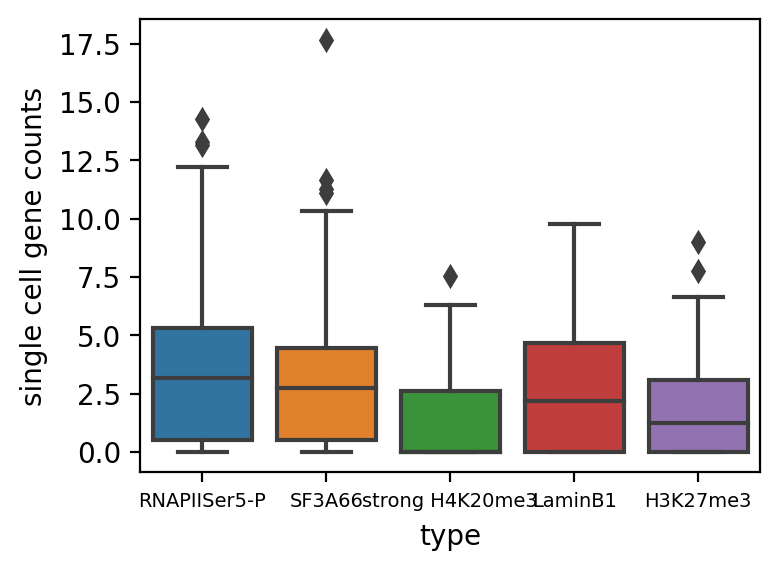

In [75]:
# compare the expression of H4K20me3 bins with other control bins in Purkinje cells
check_ct = "Purkinje"
#check gene count
plot_df = sc_df.copy()
plot_df["type"] = 0

####### specify the markers you want to check, if "strong H4K20me3" use the fixed gene set, if other markers check the genes located in the marker peak in check_ct #####
check_markers = ["RNAPIISer5-P", "SF3A66", "strong H4K20me3", "LaminB1", "H3K27me3"]

for m in check_markers:
    if m == "strong H4K20me3":
        plot_df.loc[plot_df["gene"].isin(gene_dict[m]), "type"] = m
    else:
        plot_df.loc[plot_df["gene"].isin(gene_dict[f"{check_ct}_{m}"]), "type"] = m

sub_df = plot_df[plot_df["type"] != 0][["gene", "type", "VIIb_F002_Purkinje"]]
plt.figure(figsize = (4, 3))
sns.boxplot(sub_df, x = "type", y = f"VIIb_F002_{check_ct}", order = ["RNAPIISer5-P", "SF3A66", "strong H4K20me3", "LaminB1", "H3K27me3"])
plt.ylabel("single cell gene counts")
plt.legend(frameon = False, bbox_to_anchor = (1.0, 1.0))
plt.xticks(fontsize = 7)


No handles with labels found to put in legend.


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'RNAPIISer5-P'),
  Text(1, 0, 'SF3A66'),
  Text(2, 0, 'strong H4K20me3'),
  Text(3, 0, 'LaminB1'),
  Text(4, 0, 'H3K27me3')])

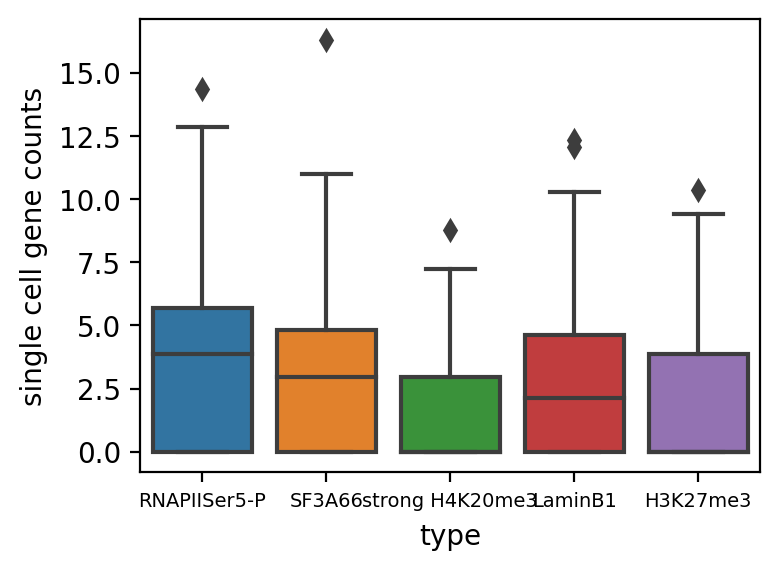

In [76]:
# compare the expression of H4K20me3 bins with other control bins in Purkinje cells
check_ct = "Bergmann"
#check gene count
plot_df = sc_df.copy()
plot_df["type"] = 0
check_markers = ["RNAPIISer5-P", "SF3A66", "strong H4K20me3", "LaminB1", "H3K27me3"]

for m in check_markers:
    if m == "strong H4K20me3":
        plot_df.loc[plot_df["gene"].isin(gene_dict[m]), "type"] = m
    else:
        plot_df.loc[plot_df["gene"].isin(gene_dict[f"{check_ct}_{m}"]), "type"] = m

sub_df = plot_df[plot_df["type"] != 0][["gene", "type", f"VIIb_F002_{check_ct}"]]
plt.figure(figsize = (4, 3))
sns.boxplot(sub_df, x = "type", y = f"VIIb_F002_{check_ct}", order = ["RNAPIISer5-P", "SF3A66", "strong H4K20me3", "LaminB1", "H3K27me3"])
plt.ylabel("single cell gene counts")
plt.legend(frameon = False, bbox_to_anchor = (1.0, 1.0))
plt.xticks(fontsize = 7)

No handles with labels found to put in legend.


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'RNAPIISer5-P'),
  Text(1, 0, 'SF3A66'),
  Text(2, 0, 'strong H4K20me3'),
  Text(3, 0, 'LaminB1'),
  Text(4, 0, 'H3K27me3')])

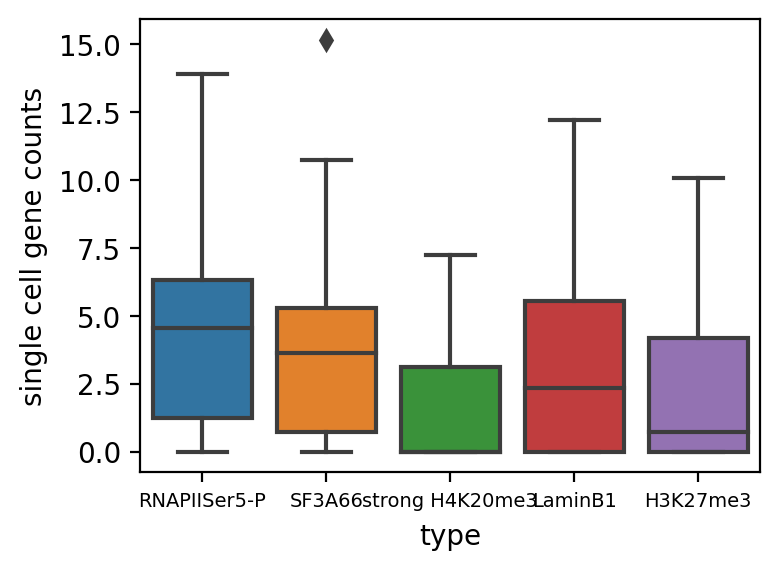

In [77]:
# compare the expression of H4K20me3 bins with other control bins in Purkinje cells
check_ct = "MLI1"
#check gene count
plot_df = sc_df.copy()
plot_df["type"] = 0
check_markers = ["RNAPIISer5-P", "SF3A66", "strong H4K20me3", "LaminB1", "H3K27me3"]

for m in check_markers:
    if m == "strong H4K20me3":
        plot_df.loc[plot_df["gene"].isin(gene_dict[m]), "type"] = m
    else:
        plot_df.loc[plot_df["gene"].isin(gene_dict[f"{check_ct}_{m}"]), "type"] = m

sub_df = plot_df[plot_df["type"] != 0][["gene", "type", f"VIIb_F002_{check_ct}"]]
plt.figure(figsize = (4, 3))
sns.boxplot(sub_df, x = "type", y = f"VIIb_F002_{check_ct}", order = ["RNAPIISer5-P", "SF3A66", "strong H4K20me3", "LaminB1", "H3K27me3"])
plt.ylabel("single cell gene counts")
plt.legend(frameon = False, bbox_to_anchor = (1.0, 1.0))
plt.xticks(fontsize = 7)

No handles with labels found to put in legend.


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'RNAPIISer5-P'),
  Text(1, 0, 'SF3A66'),
  Text(2, 0, 'strong H4K20me3'),
  Text(3, 0, 'LaminB1'),
  Text(4, 0, 'H3K27me3')])

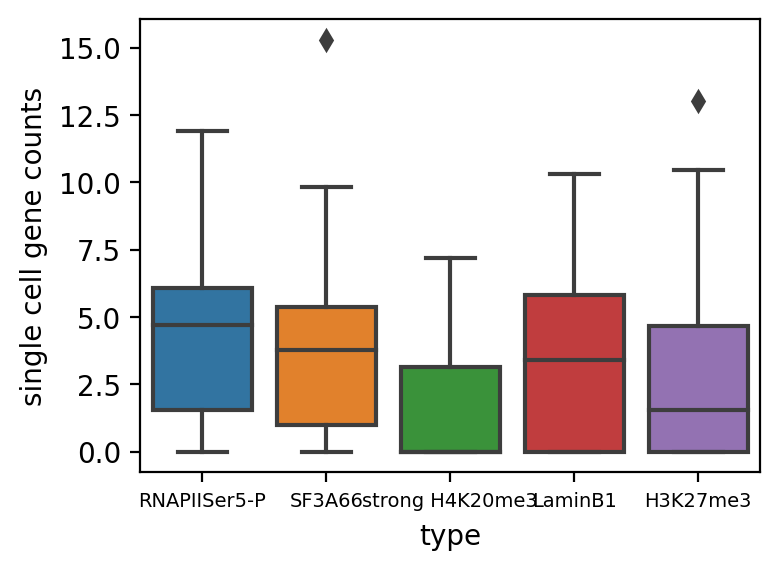

In [78]:
# compare the expression of H4K20me3 bins with other control bins in Purkinje cells
check_ct = "MLI2+PLI"
#check gene count
plot_df = sc_df.copy()
plot_df["type"] = 0
check_markers = ["RNAPIISer5-P", "SF3A66", "strong H4K20me3", "LaminB1", "H3K27me3"]

for m in check_markers:
    if m == "strong H4K20me3":
        plot_df.loc[plot_df["gene"].isin(gene_dict[m]), "type"] = m
    else:
        plot_df.loc[plot_df["gene"].isin(gene_dict[f"{check_ct}_{m}"]), "type"] = m

sub_df = plot_df[plot_df["type"] != 0][["gene", "type", f"VIIb_F002_{check_ct}"]]
plt.figure(figsize = (4, 3))
sns.boxplot(sub_df, x = "type", y = f"VIIb_F002_{check_ct}", order = ["RNAPIISer5-P", "SF3A66", "strong H4K20me3", "LaminB1", "H3K27me3"])
plt.ylabel("single cell gene counts")
plt.legend(frameon = False, bbox_to_anchor = (1.0, 1.0))
plt.xticks(fontsize = 7)

# Code below draws the volcano plot for differential expression

#### This block is to remain genes in H4K20me3 strong bins that the whole gene bodies are within the strong H4K20me3 peaks

In [79]:
# get gene information
gene_info = pd.read_csv(str(data_root / "annotation" / "mm10_25kb_bins_genes_new.csv"), header = None).iloc[:, [0, 1, 2, 3,5]]
gene_info.columns = ["name", "chrom", "start", "end", "gene"]
# align to 200kb name
bin_info = pd.read_csv(str(data_root / "annotation" / "LC1-100k-25kb-100kb-200kb-paint-mm10-annotation.csv"))
gene_info = gene_info.merge(bin_info[["name","200kb name"]])
gene_info = gene_info.merge(H4_df[["200kb name", "H4K20me3_cat5"]])

/Users/yujingyang/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


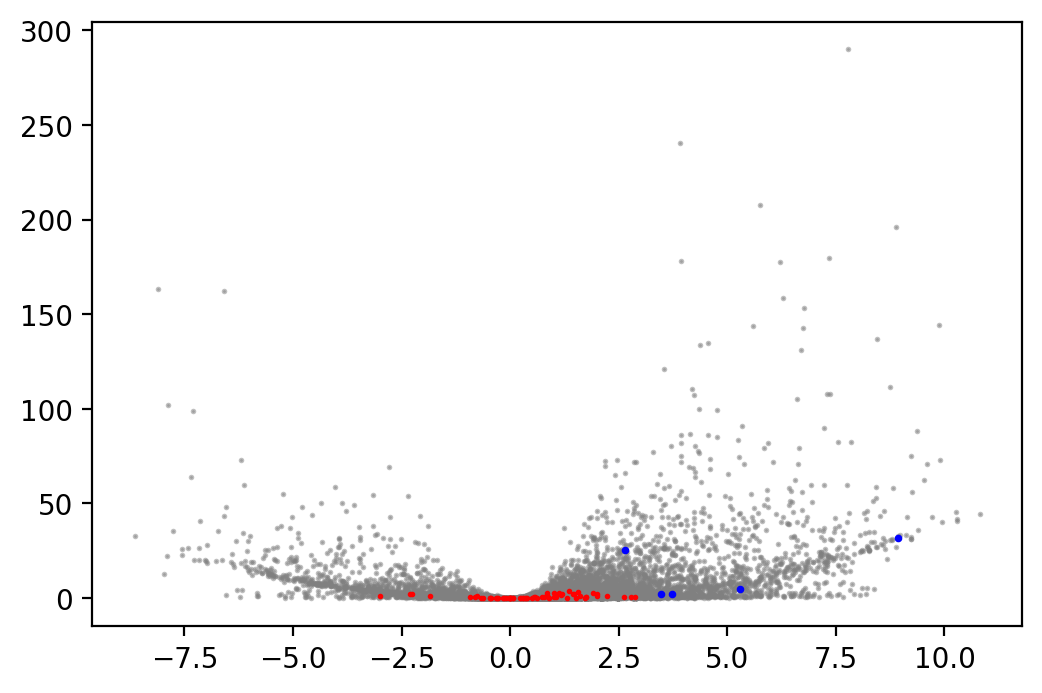

0.022321428571428572 changed expression


In [80]:
# volcano plot
#bg
gs = gene_dict["strong H4K20me3"]

############ specify the cell pair you want to check ##################
check_ct1 = "Bergmann"
check_ct2 = "Purkinje"


de_df = pd.read_csv( str(data_root / experiment /  "differential_expression"/ "RNA_DE"/ f"deg_deseq2_ensemble_{check_ct1}_{check_ct2}.txt"), sep = "\t")
de_df = de_df.reset_index()
de_df.rename(columns = {"index" : "gene"}, inplace = True)

g = gene_dict["strong H4K20me3"]
# filter out genes that gene body does not all belong to the strong peak
sub_gene = gene_info[gene_info["gene"].isin(g)]
filter_gs = sub_gene[sub_gene["H4K20me3_cat5"] != 2]["gene"].unique().tolist()
plt.scatter( de_df["log2FoldChange"], -np.log10(de_df["padj"]), s = 1, c = "grey", alpha = 0.5)
sdf = de_df[de_df["gene"].isin(set(g) - set(filter_gs) )]
plt.scatter( sdf["log2FoldChange"], -np.log10(sdf["padj"]), s = 1, c = "red", alpha = 1)

# de genes are in blue dots, change threshold here
outlier_sdf = sdf[(sdf["log2FoldChange"].abs() > 2.5) & (sdf["padj"] < 0.01)]
plt.scatter( outlier_sdf["log2FoldChange"], -np.log10(outlier_sdf["padj"]), s = 3, c = "blue", alpha = 1)
plt.show()
# print changed fraction
print (f"{len(outlier_sdf) / len(sdf)} changed expression" )

In [33]:
# check outlier genes
outlier_sdf

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
305,Hif3a,1.159009,8.922927,0.731450,12.198962,3.148128e-34,1.382193e-32
457,Asap2,4.104516,2.648182,0.244474,10.832166,2.423525e-27,7.109183e-26
2225,Mill2,1.026878,5.282191,1.100040,4.801818,1.572313e-06,9.489680e-06
3590,Wtip,1.113384,3.475633,1.059421,3.280690,1.035536e-03,3.874247e-03
3751,Vmn2r29,0.266062,3.717248,1.173544,3.167541,1.537341e-03,5.503955e-03


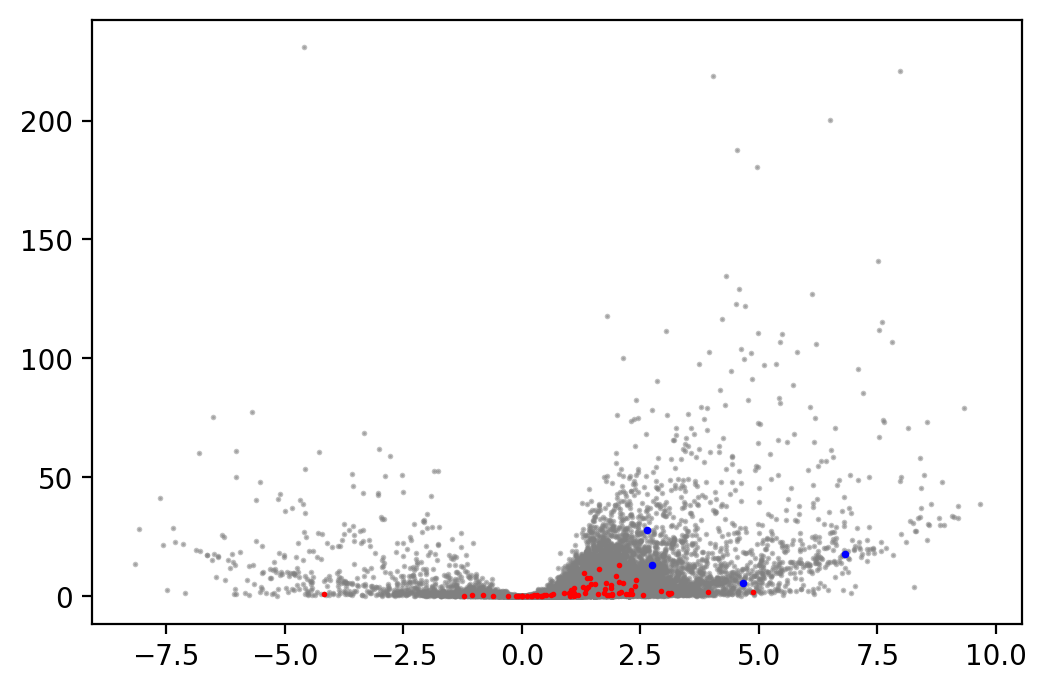

0.017857142857142856 changed expression


In [59]:
gs = gene_dict["strong H4K20me3"]

# specify the cell pair you want to check, MLI1 vs Purkinje here
check_ct1 = "MLI1"
check_ct2 = "Purkinje"
de_df = pd.read_csv( str(data_root / experiment /  "differential_expression"/ "RNA_DE"/ f"deg_deseq2_ensemble_{check_ct1}_{check_ct2}.txt"), sep = "\t")
de_df = de_df.reset_index()
de_df.rename(columns = {"index" : "gene"}, inplace = True)

g = gene_dict["strong H4K20me3"]
# filter out genes that gene body does not all belong to the strong peak
sub_gene = gene_info[gene_info["gene"].isin(g)]
filter_gs = sub_gene[sub_gene["H4K20me3_cat5"] != 2]["gene"].unique().tolist()
plt.scatter( de_df["log2FoldChange"], -np.log10(de_df["padj"]), s = 1, c = "grey", alpha = 0.5)
sdf = de_df[de_df["gene"].isin(set(g) - set(filter_gs) )]
plt.scatter( sdf["log2FoldChange"], -np.log10(sdf["padj"]), s = 1, c = "red", alpha = 1)

# de genes are in blue dots, change threshold here
outlier_sdf = sdf[(sdf["log2FoldChange"].abs() > 2.5) & (sdf["padj"] < 0.01)]
plt.scatter( outlier_sdf["log2FoldChange"], -np.log10(outlier_sdf["padj"]), s = 3, c = "blue", alpha = 1)
plt.show()
print (f"{len(outlier_sdf) / len(sdf)} changed expression" )

In [60]:
# check outlier genes
outlier_sdf

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
452,Asap2,4.104516,2.640017,0.231536,11.402195,4.077081e-30,1.245805e-28
1014,Ptpn5,0.899074,6.811909,0.750914,9.071496,1.173941e-19,1.600955e-18
1611,Pdcd2l,1.191322,2.739480,0.354458,7.728642,1.087000e-14,9.333906e-14
4062,Wtip,1.113384,4.656321,0.951268,4.894856,9.837791e-07,3.351580e-06


# Use PolII genes as control
# PolII genes can be up/down regulated across cell types

/Users/yujingyang/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


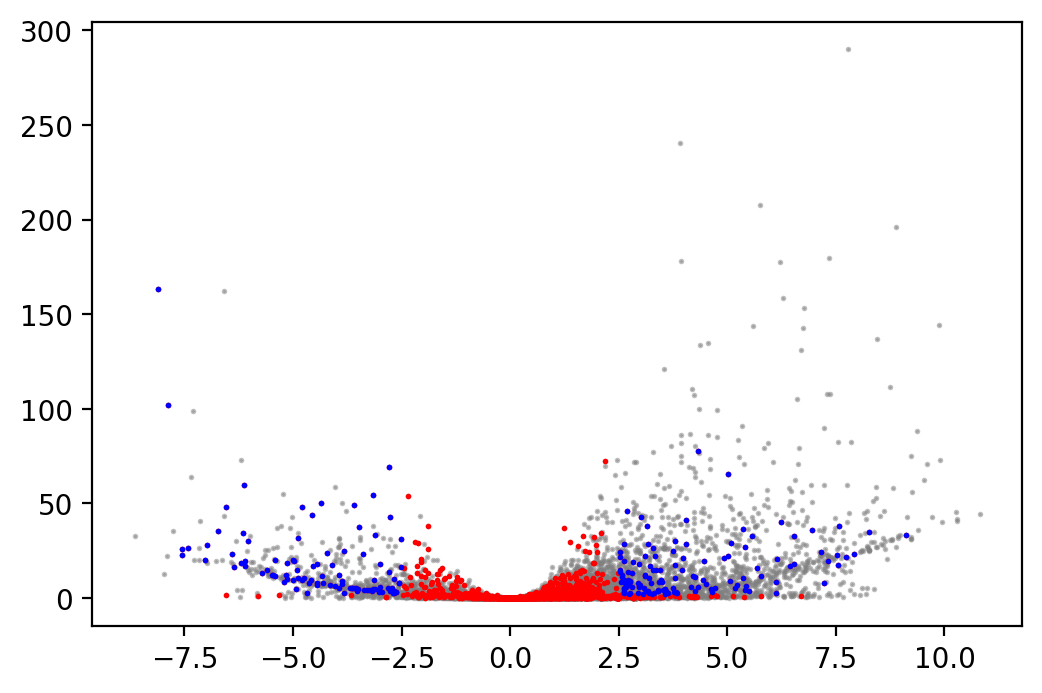

0.1124558749369642 changed expression


In [62]:
# check RNAPIISer05 peak genes
check_ct1 = "Bergmann"
check_ct2 = "Purkinje"
de_df = pd.read_csv( str(data_root / experiment /  "differential_expression"/ "RNA_DE"/ f"deg_deseq2_ensemble_{check_ct1}_{check_ct2}.txt"), sep = "\t")
de_df = de_df.reset_index()
de_df.rename(columns = {"index" : "gene"}, inplace = True)

# check genes that under Purkinje polII
g = gene_dict["Purkinje_RNAPIISer5-P"]

plt.scatter( de_df["log2FoldChange"], -np.log10(de_df["padj"]), s = 1, c = "grey", alpha = 0.5)
sdf = de_df[de_df["gene"].isin(g)]
plt.scatter( sdf["log2FoldChange"], -np.log10(sdf["padj"]), s = 1, c = "red", alpha = 1)
outlier_sdf = sdf[(sdf["log2FoldChange"].abs() > 2.5) & (sdf["padj"] < 0.01)]
plt.scatter( outlier_sdf["log2FoldChange"], -np.log10(outlier_sdf["padj"]), s = 1, c = "blue", alpha = 1)
plt.show()
print (f"{len(outlier_sdf) / len(sdf)} changed expression" )

/Users/yujingyang/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


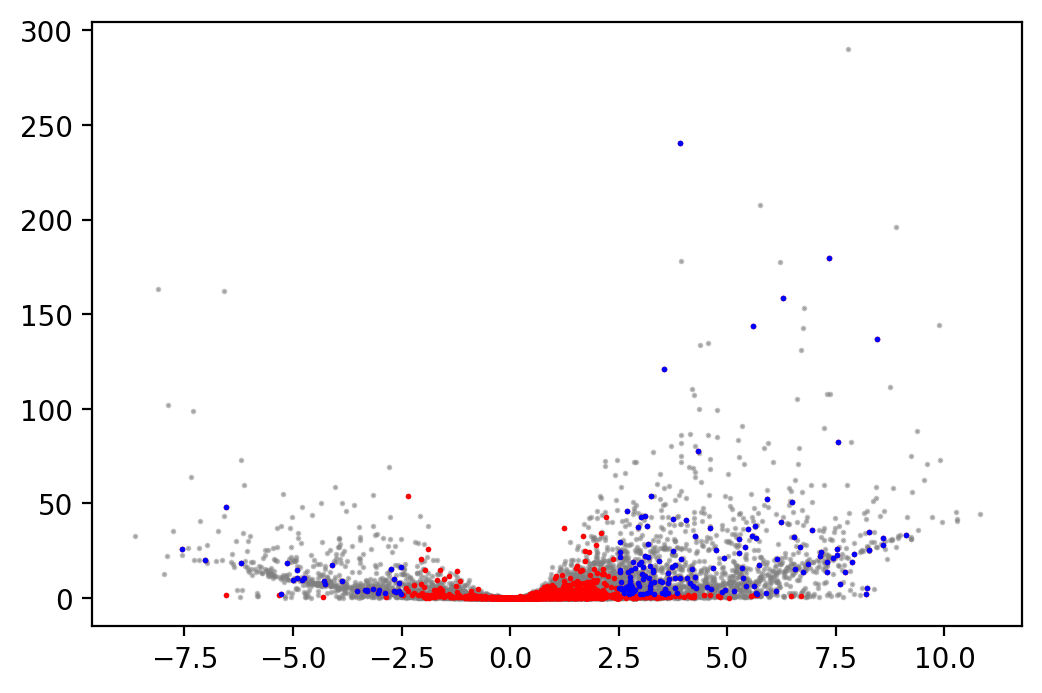

0.09170530654301906 changed expression


In [64]:
# check RNAPIISer05 peak genes
check_ct1 = "Bergmann"
check_ct2 = "Purkinje"
de_df = pd.read_csv( str(data_root / experiment /  "differential_expression"/ "RNA_DE"/ f"deg_deseq2_ensemble_{check_ct1}_{check_ct2}.txt"), sep = "\t")
de_df = de_df.reset_index()
de_df.rename(columns = {"index" : "gene"}, inplace = True)

# check genes that under Bergmann polII
g = gene_dict["Bergmann_RNAPIISer5-P"]

plt.scatter( de_df["log2FoldChange"], -np.log10(de_df["padj"]), s = 1, c = "grey", alpha = 0.5)
sdf = de_df[de_df["gene"].isin(g)]
plt.scatter( sdf["log2FoldChange"], -np.log10(sdf["padj"]), s = 1, c = "red", alpha = 1)
outlier_sdf = sdf[(sdf["log2FoldChange"].abs() > 2.5) & (sdf["padj"] < 0.01)]
plt.scatter( outlier_sdf["log2FoldChange"], -np.log10(outlier_sdf["padj"]), s = 1, c = "blue", alpha = 1)
plt.show()
print (f"{len(outlier_sdf) / len(sdf)} changed expression" )